In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
import pickle
import torch
from torch import nn
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
print(torch.__version__)

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

2.3.0+cu121
Using cpu device


__Getting data__

In [3]:
stock = "RR.L.csv"
train = pd.read_csv("../data/train/" + stock).set_index("Date")
validation = pd.read_csv("../data/validation/" + stock).set_index("Date")
test = pd.read_csv("../data/test/" + stock).set_index("Date")
train = pd.concat([train, validation], axis = 0)
train

,Open,High,Low,Close,Adj Close,Volume,Change[%]
Date,,,,,,,
2012-01-03,0.548936,0.549805,0.547816,0.544075,0.464206,0.032030,0.308960
2012-01-04,0.554043,0.551489,0.550373,0.538156,0.459025,0.029692,0.294358
2012-01-05,0.543404,0.544753,0.549947,0.541538,0.461985,0.046308,0.317382
2012-01-06,0.546809,0.546016,0.554209,0.542806,0.463095,0.042678,0.312101
2012-01-09,0.548085,0.547279,0.555487,0.543652,0.463836,0.020215,0.311050
...,...,...,...,...,...,...,...
2023-11-16,0.507394,0.509788,0.512433,0.506427,0.506427,0.356570,0.314794
2023-11-17,0.511576,0.512978,0.516158,0.505195,0.505195,0.099675,0.305731
2023-11-20,0.507608,0.511751,0.516655,0.508891,0.508891,0.064128,0.318668


__Date Embedding and cyclical transformation__

In [4]:

def getDateRange(start_date, end_date):
    current_date = start_date
    dates = []
    while current_date <= end_date:
        dates.append(current_date.strftime('%Y-%m-%d'))
        current_date += timedelta(days=1)
    return dates

# Define the date range
start_date = datetime(2024, 5, 24) - timedelta(days=40*365)  # 40 years ago
end_date = datetime(2024, 5, 24) + timedelta(days=40*365)    # 40 years in the future

# Generate the list of dates
dictionary = getDateRange(start_date, end_date)
date_to_index = {date: index for index, date in enumerate(dictionary)}

class DateEmbeddingModel(nn.Module):
    def __init__(self, num_embeddings = 29201, embedding_dim = 8):
        super(DateEmbeddingModel, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)

    def forward(self, dates):
        date_indices = torch.tensor([date_to_index[date] for date in dates], dtype=torch.long)
        embedded_dates = self.embedding(date_indices)
        return embedded_dates

In [5]:
def dateCyclicalTransformation(date):
    date = pd.to_datetime(date)

    monthSin = np.sin(2 * np.pi * date.month/12.0)
    monthCos = np.cos(2 * np.pi * date.month/12.0)
    daySin = np.sin(2 * np.pi * date.day/31.0)
    dayCos = np.cos(2 * np.pi * date.day/31.0)

    return [monthSin, monthCos, daySin, dayCos]

In [6]:
'''date = train.index.map(dateCyclicalTransformation)
date = pd.DataFrame(date.to_list(), columns = ["monthSin", "monthCos", "daySin", "dayCos"]).set_index(train.index)
train = train.join(date)

date = validation.index.map(dateCyclicalTransformation)
date = pd.DataFrame(date.to_list(), columns = ["monthSin", "monthCos", "daySin", "dayCos"]).set_index(validation.index)
validation = validation.join(date)

date = test.index.map(dateCyclicalTransformation)
date = pd.DataFrame(date.to_list(), columns = ["monthSin", "monthCos", "daySin", "dayCos"]).set_index(test.index)
test = test.join(date)'''

'date = train.index.map(dateCyclicalTransformation)\ndate = pd.DataFrame(date.to_list(), columns = ["monthSin", "monthCos", "daySin", "dayCos"]).set_index(train.index)\ntrain = train.join(date)\n\ndate = validation.index.map(dateCyclicalTransformation)\ndate = pd.DataFrame(date.to_list(), columns = ["monthSin", "monthCos", "daySin", "dayCos"]).set_index(validation.index)\nvalidation = validation.join(date)\n\ndate = test.index.map(dateCyclicalTransformation)\ndate = pd.DataFrame(date.to_list(), columns = ["monthSin", "monthCos", "daySin", "dayCos"]).set_index(test.index)\ntest = test.join(date)'

__Creating data loader for trend__

In [7]:
def createSequenceForTrend(dataX, dataY, lengthX, predictionHorizont):
    xData = []
    yData = []
    for i in range(len(dataX) - lengthX - predictionHorizont):
        xData.append(dataX[i:i+lengthX].values)

        if(dataY[lengthX+i - 1] <= dataY[lengthX + predictionHorizont + i - 1]):
            yData.append(1)
        else:
            yData.append(0)
    return xData, yData

xTrain, yTrain = createSequenceForTrend(train, train["Close"], 2, 1)
xValid, yValid = createSequenceForTrend(validation, validation["Close"], 2, 1)
xTest, yTest = createSequenceForTrend(test, test["Close"], 2, 1)

/tmp/ipykernel_32303/4026226926.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if(dataY[lengthX+i - 1] <= dataY[lengthX + predictionHorizont + i - 1]):


__Model__

In [8]:
xTrain = np.array(xTrain)
yTrain = np.array(yTrain)
xValidation = np.array(xValid)
yValidation = np.array(yValid)
xTest = np.array(xTest)
yTest = np.array(yTest)

num_samples, num_days, num_features = xTrain.shape
xTrain_flattened = xTrain.reshape(num_samples, num_days * num_features)

num_samples, num_days, num_features = xValidation.shape
xValidation_flattened = xValidation.reshape(num_samples, num_days * num_features)

num_samples, num_days, num_features = xTest.shape
xTest_flattened = xTest.reshape(num_samples, num_days * num_features)

In [9]:
svr = SVC(kernel='rbf', degree=10, C=200000.0, max_iter=-1, tol = 1e-3)
svr.fit(xTrain_flattened, yTrain)
#pickle.dump(svr, open("../models/svr_params.pickle", "wb"))

# Load the parameters from file
#svrMultiOutput = pickle.load(open("../models/svr_params.pickle", "rb"))


SVC(C=200000.0, degree=10)

__Train results__

Accuracy: 0.6467844051982673
Recall: 0.7052287581699347


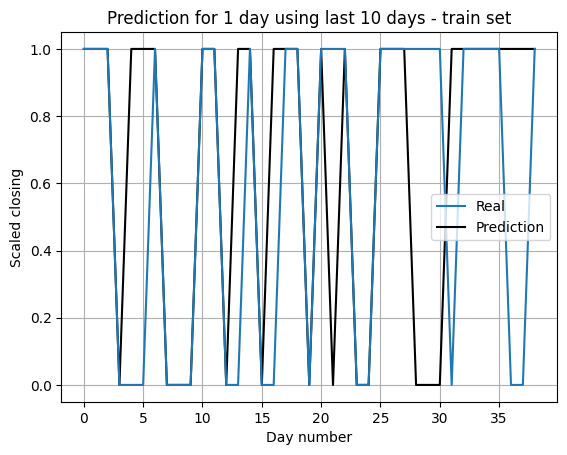

In [10]:
# Make predictions
y_pred = svr.predict(xTrain_flattened)

# Calculate the mean squared error across all outputs
accuracy_total = accuracy_score(yTrain, y_pred)
print(f'Accuracy: {accuracy_total}')

recall_total = recall_score(yTrain, y_pred)
print(f'Recall: {recall_total}')

real = yTrain[1:40]
predictions = y_pred[1:40]

fig, ax = plt.subplots()
ax.plot(real, zorder = 3)
ax.plot(predictions, color = 'black', zorder = 2)
ax.legend(["Real", "Prediction"])
#ax.axvspan(0, 4, facecolor='lightblue', alpha=0.5, zorder = 1)  # First part
#ax.axvspan(4, 9, facecolor='lightgreen', alpha=0.5, zorder = 1)  # Second part
#ax.axvspan(9, 14, facecolor='tomato', alpha=0.5, zorder = 1)  # Second third
#ax.set_ylim([0, 1])
ax.grid()
plt.ylabel("Scaled closing")
plt.xlabel("Day number")
plt.title("Prediction for 1 day using last 10 days - train set")
plt.show()



__Test results__

In [11]:
# Make predictions
y_pred = svr.predict(xTest_flattened)

# Print the shape of predictions to verify
print(y_pred.shape)  # Should be (num_samples, prediction horizont)

(123,)


In [12]:
# Calculate the mean squared error across all outputs
accuracy_total = accuracy_score(yTest, y_pred)
print(f'Accuracy: {accuracy_total}')

recall_total = recall_score(yTest, y_pred)
print(f'Recall: {recall_total}')

Accuracy: 0.5447154471544715
Recall: 0.5846153846153846


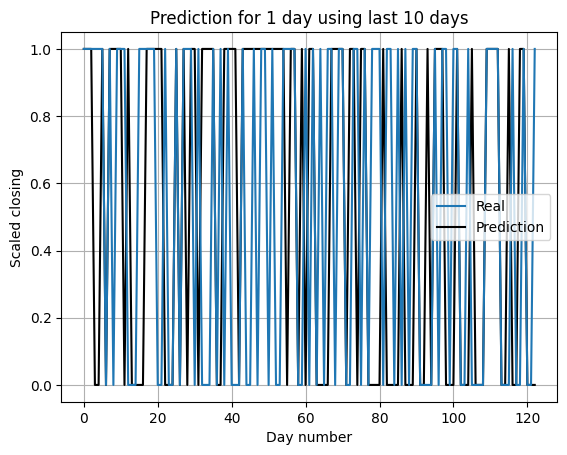

In [13]:
real = yTest
predictions = y_pred

fig, ax = plt.subplots()
ax.plot(real, zorder = 3)
ax.plot(predictions, color = 'black', zorder = 2)
ax.legend(["Real", "Prediction"])
#ax.axvspan(0, 4, facecolor='lightblue', alpha=0.5, zorder = 1)  # First part
#ax.axvspan(4, 9, facecolor='lightgreen', alpha=0.5, zorder = 1)  # Second part
#ax.axvspan(9, 14, facecolor='tomato', alpha=0.5, zorder = 1)  # Second third
#ax.set_ylim([0, 1])
ax.grid()
plt.ylabel("Scaled closing")
plt.xlabel("Day number")
plt.title("Prediction for 1 day using last 10 days")
plt.show()